In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

### Data Import

In [2]:
df = pd.read_csv('train.csv')

df.head(5)

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,CreditScore
0,22,14,8557.39,797.115833,8,6,22,2,37,15.0,...,0,1767.29,25.400823,143,2,13.168404,91.952879,3.0,264.590301,2
1,37,1,19718.92,1676.243333,10,9,19,6,27,11.0,...,2,2057.56,28.642449,197,2,64.066440,107.668408,3.0,285.889485,2
2,33,13,32045.78,2677.481667,6,9,30,7,10,10.0,...,2,1333.18,30.053861,76,2,169.770374,62.681178,4.0,285.296615,2
3,42,4,62976.28,5321.023333,0,3,12,0,9,0.0,...,1,68.66,40.661773,191,1,0.000000,70.780837,4.0,711.321496,1
4,39,2,57818.72,4864.226667,7,7,21,2,56,16.0,...,0,2348.77,37.882655,174,2,73.709570,395.136222,3.0,307.576874,2


In [3]:
X_df, y_df = df.drop(['CreditScore'], axis=1), df['CreditScore']

X_train, X_valid, y_train, y_valid = train_test_split(X_df, y_df, test_size=0.1, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Valid shape:", X_valid.shape, y_valid.shape)

Train shape: (76743, 21) (76743,)
Valid shape: (8527, 21) (8527,)


### Imbalanced Visualize

Class weight: {0: 1.8244775693602453, 1: 6.167564092260709, 2: 3.451139991905383} 

Train label count:
0    42063
1    12443
2    22237
Name: CreditScore, dtype: int64


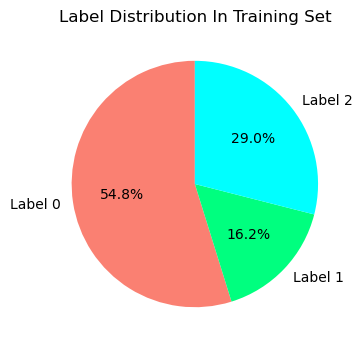

In [4]:
y_train_imbalanced = y_train.value_counts().sort_index()
# class_weights = [y_train.shape[0] / item[1] for item in y_train_imbalanced.items()]
class_weights = {cls: y_train.shape[0] / count for cls, count in y_train_imbalanced.items()}
print("Class weight:", class_weights, '\n')
print(f"Train label count:\n{y_train_imbalanced}")

plt.figure(figsize=(4, 4))
plt.pie(y_train_imbalanced, labels=['Label 0', 'Label 1', 'Label 2'], autopct='%1.1f%%', startangle=90, colors=['salmon','springgreen', 'cyan'])
plt.title('Label Distribution In Training Set')
plt.show()

Valid label count:
0    4675
1    1381
2    2471
Name: CreditScore, dtype: int64


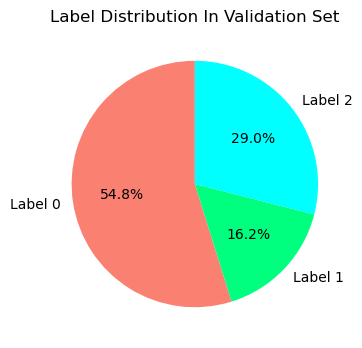

In [5]:
y_valid_imbalanced = y_valid.value_counts().sort_index()
print(f"Valid label count:\n{y_valid_imbalanced}")

plt.figure(figsize=(4, 4))
plt.pie(y_valid_imbalanced, labels=['Label 0', 'Label 1', 'Label 2'], autopct='%1.1f%%', startangle=90, colors=['salmon','springgreen', 'cyan'])
plt.title('Label Distribution In Validation Set')
plt.show()

### Data Preprocess

In [6]:
categorical_features = ['col_2', 'col_13', 'col_17', 'col_20']

# handle missing value
num_imputer = SimpleImputer(strategy='median')
X_train_num = num_imputer.fit_transform(X_train.drop(categorical_features, axis=1))
X_valid_num = num_imputer.transform(X_valid.drop(categorical_features, axis=1))

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = cat_imputer.fit_transform(X_train[categorical_features])
X_valid_cat = cat_imputer.transform(X_valid[categorical_features])

# Normalize
sc = StandardScaler()
X_train_num = sc.fit_transform(X_train_num)
X_valid_num = sc.transform(X_valid_num)

# PCA
# ratio = 0.9
# n_components = int(X_train_num.shape[1] * ratio)
# pca = PCA(n_components=n_components)
# X_train_num = pca.fit_transform(X_train_num)
# X_valid_num = pca.transform(X_valid_num)

# One Hot Encoding
# encoder = OneHotEncoder()
# X_train_cat = encoder.fit_transform(X_train_cat).toarray()
# X_valid_cat = encoder.transform(X_valid_cat).toarray()

In [7]:
# Concatenation
# X_train = np.hstack([X_train_num, X_train_cat])
# X_valid = np.hstack([X_valid_num, X_valid_cat])
X_train = X_train_num
X_valid = X_valid_num

# Polynomial feature
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_valid = poly.transform(X_valid)

print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")

Train: (76743, 171), Valid: (8527, 171)


In [8]:
# Smote
smote = SMOTE(random_state=42)
smote_tomek = SMOTETomek(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_tomek, y_train_tomek = smote_tomek.fit_resample(X_train, y_train)

print(X_train_smote.shape, X_train_tomek.shape)

(126189, 171) (122171, 171)


### Ensemble Model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#### Random Forest

In [22]:
# Training
rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
)

rf.fit(X_train_tomek, y_train_tomek)

y_pred_train = rf.predict(X_train)
y_pred_val =  rf.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

F1-score on train: 0.9829386318061535
F1-score on valid: 0.7751005370931039


[('Feature 0', 0.0), ('Feature 13', 0.002635719356351655), ('Feature 3', 0.002656627278400613), ('Feature 17', 0.0026891359750725492), ('Feature 53', 0.002727684901675091), ('Feature 63', 0.0027340912383565074), ('Feature 88', 0.0027356866978445167), ('Feature 92', 0.002758232715206352), ('Feature 158', 0.0027612303276930445), ('Feature 30', 0.0027702682629390752), ('Feature 149', 0.0027797700037839206), ('Feature 145', 0.002796474106670173), ('Feature 59', 0.0028006143379091636), ('Feature 100', 0.0028008432414104423), ('Feature 104', 0.0028065194476997336), ('Feature 79', 0.002808769230994778), ('Feature 34', 0.00282732601245396), ('Feature 75', 0.002832426792814466), ('Feature 167', 0.0028713383884839743), ('Feature 52', 0.0029145163993902247), ('Feature 130', 0.0029187167778967553), ('Feature 54', 0.002921456705742787), ('Feature 134', 0.002921736532583439), ('Feature 20', 0.002922068107177531), ('Feature 111', 0.0029312482108282707), ('Feature 46', 0.0029712432179309052), ('Featur

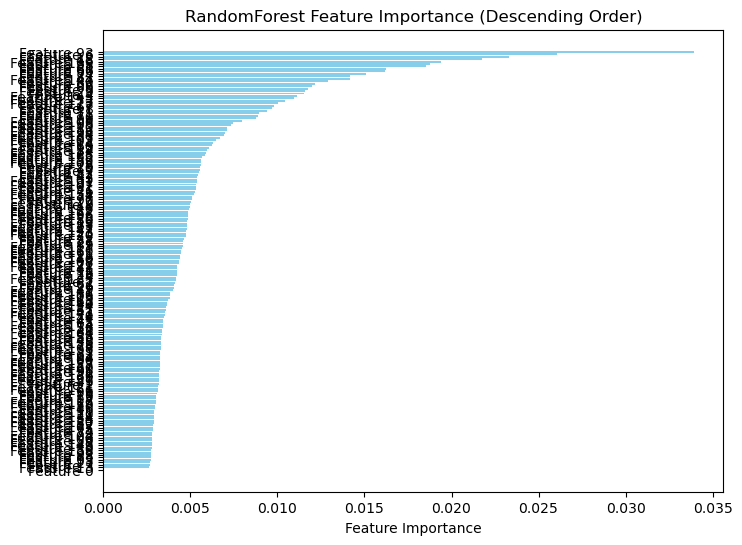

In [23]:
# feature importance visualization
rf_feature_importances = rf.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(rf_feature_importances))]

features_importance_sorted = sorted(zip(feature_names, rf_feature_importances), key=lambda x: x[1])
feature_names_sorted, feature_importances_sorted = zip(*features_importance_sorted)
print(features_importance_sorted)

plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('RandomForest Feature Importance (Descending Order)')
plt.show()

In [24]:
# select feature
rf_threshold = 0.02

X_train_selected_rf = X_train_tomek[:, rf_feature_importances > rf_threshold]
X_valid_selected_rf = X_valid[:, rf_feature_importances > rf_threshold]

print(X_train_selected_rf.shape)
print(X_valid_selected_rf.shape)

(122171, 4)
(8527, 4)


In [25]:
# Re-Train model using selected feature
rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
)

rf.fit(X_train_selected_rf, y_train_tomek)

y_pred_val = rf.predict(X_valid_selected_rf)

print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

F1-score on valid: 0.7823235657875118


#### XGBoost

In [26]:
# Training
xgb = XGBClassifier(
    n_estimators=500, 
    max_depth=7, 
    early_stopping_rounds=50,
    reg_lambda=1.2, 
    min_child_weight=4,
    n_jobs=-1
)

eval_set = [(X_train_smote, y_train_smote), (X_valid, y_valid)]

xgb.fit(X_train_smote, y_train_smote, eval_set=eval_set, verbose=10)

y_pred_train = xgb.predict(X_train)
y_pred_val =  xgb.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 


[0]	validation_0-mlogloss:0.93471	validation_1-mlogloss:0.96641
[10]	validation_0-mlogloss:0.56091	validation_1-mlogloss:0.69125
[20]	validation_0-mlogloss:0.48273	validation_1-mlogloss:0.64841
[30]	validation_0-mlogloss:0.43690	validation_1-mlogloss:0.62592
[40]	validation_0-mlogloss:0.40326	validation_1-mlogloss:0.60905
[50]	validation_0-mlogloss:0.37542	validation_1-mlogloss:0.59683
[60]	validation_0-mlogloss:0.34965	validation_1-mlogloss:0.58513
[70]	validation_0-mlogloss:0.32925	validation_1-mlogloss:0.57579
[80]	validation_0-mlogloss:0.30915	validation_1-mlogloss:0.56970
[90]	validation_0-mlogloss:0.29094	validation_1-mlogloss:0.56076
[100]	validation_0-mlogloss:0.27289	validation_1-mlogloss:0.55391
[110]	validation_0-mlogloss:0.25734	validation_1-mlogloss:0.54828
[120]	validation_0-mlogloss:0.24251	validation_1-mlogloss:0.54213
[130]	validation_0-mlogloss:0.22804	validation_1-mlogloss:0.53780
[140]	validation_0-mlogloss:0.21622	validation_1-mlogloss:0.53537
[150]	validation_0-ml

[('Feature 0', 0.0), ('Feature 111', 0.0013890775), ('Feature 156', 0.0014232408), ('Feature 170', 0.0014494895), ('Feature 30', 0.0014522861), ('Feature 157', 0.0014608267), ('Feature 13', 0.0014750141), ('Feature 130', 0.0014832335), ('Feature 138', 0.0014891011), ('Feature 61', 0.0014895103), ('Feature 166', 0.0014909599), ('Feature 88', 0.0014961784), ('Feature 46', 0.0015037989), ('Feature 151', 0.0015104703), ('Feature 78', 0.001511285), ('Feature 160', 0.0015242058), ('Feature 100', 0.0015542245), ('Feature 91', 0.0015542783), ('Feature 168', 0.0015707052), ('Feature 145', 0.0015863039), ('Feature 75', 0.0015939618), ('Feature 148', 0.0015996037), ('Feature 133', 0.0016136542), ('Feature 159', 0.0016220497), ('Feature 121', 0.0016468209), ('Feature 158', 0.0016776237), ('Feature 125', 0.0016827169), ('Feature 149', 0.001685068), ('Feature 114', 0.0016884055), ('Feature 169', 0.0017010749), ('Feature 33', 0.0017053218), ('Feature 79', 0.0017107892), ('Feature 163', 0.0017360325),

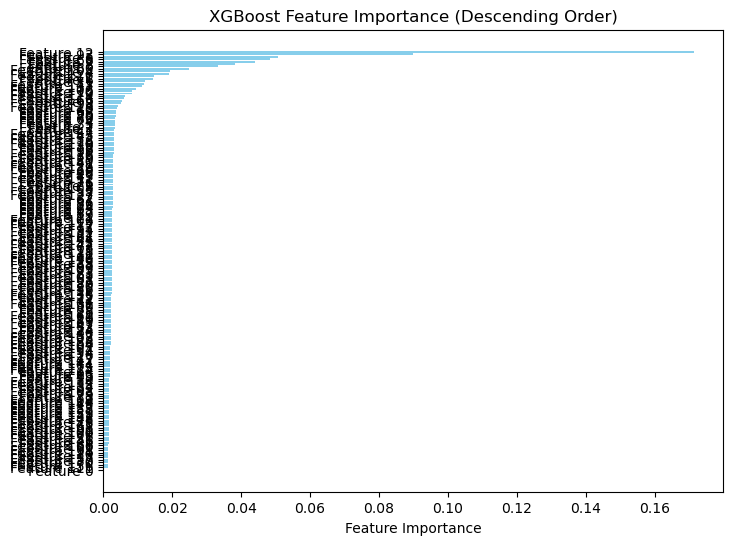

In [27]:
# feature importance visualize
xgb_feature_importances = xgb.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(xgb_feature_importances))]

features_importance_sorted = sorted(zip(feature_names, xgb_feature_importances), key=lambda x: x[1])
feature_names_sorted, feature_importances_sorted = zip(*features_importance_sorted)
print(features_importance_sorted)

plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (Descending Order)')
plt.show()

In [39]:
# select feature
xgb_threshold = 0.002

X_train_selected_xgb = X_train_smote[:, xgb_feature_importances > xgb_threshold]
X_valid_selected_xgb = X_valid[:, xgb_feature_importances > xgb_threshold]

print(X_train_selected_xgb.shape)
print(X_valid_selected_xgb.shape)

(126189, 122)
(8527, 122)


In [40]:
# Re-Train model using selected feature
xgb = XGBClassifier(
    n_estimators=800, 
    max_depth=7, 
    early_stopping_rounds=50,
    reg_lambda=1.2, 
    min_child_weight=4,
    n_jobs=-1
)

eval_set = [(X_train_selected_xgb, y_train_smote), (X_valid_selected_xgb, y_valid)]

xgb.fit(X_train_selected_xgb, y_train_smote, eval_set=eval_set, verbose=10)

y_pred_val =  xgb.predict(X_valid_selected_xgb)

print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 


[0]	validation_0-mlogloss:0.93478	validation_1-mlogloss:0.96634
[10]	validation_0-mlogloss:0.56475	validation_1-mlogloss:0.69363
[20]	validation_0-mlogloss:0.48530	validation_1-mlogloss:0.64980
[30]	validation_0-mlogloss:0.44308	validation_1-mlogloss:0.62768
[40]	validation_0-mlogloss:0.40904	validation_1-mlogloss:0.60949
[50]	validation_0-mlogloss:0.37931	validation_1-mlogloss:0.59410
[60]	validation_0-mlogloss:0.35368	validation_1-mlogloss:0.58136
[70]	validation_0-mlogloss:0.33164	validation_1-mlogloss:0.56853
[80]	validation_0-mlogloss:0.31141	validation_1-mlogloss:0.55930
[90]	validation_0-mlogloss:0.29260	validation_1-mlogloss:0.54991
[100]	validation_0-mlogloss:0.27608	validation_1-mlogloss:0.54372
[110]	validation_0-mlogloss:0.26235	validation_1-mlogloss:0.53884
[120]	validation_0-mlogloss:0.24836	validation_1-mlogloss:0.53322
[130]	validation_0-mlogloss:0.23630	validation_1-mlogloss:0.52814
[140]	validation_0-mlogloss:0.22454	validation_1-mlogloss:0.52437
[150]	validation_0-ml

#### CatBoost

In [41]:
# Training
cat = CatBoostClassifier(
    iterations=8000,
    class_weights=class_weights,
    early_stopping_rounds=50,
    devices='0:1',
    verbose=True
)

cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=10)

y_pred_train = cat.predict(X_train)
y_pred_val =  cat.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

Learning rate set to 0.053217
0:	learn: 1.0686390	test: 1.0687749	best: 1.0687749 (0)	total: 111ms	remaining: 14m 47s
10:	learn: 0.8932659	test: 0.8931459	best: 0.8931459 (10)	total: 468ms	remaining: 5m 39s
20:	learn: 0.8182800	test: 0.8168133	best: 0.8168133 (20)	total: 801ms	remaining: 5m 4s
30:	learn: 0.7810186	test: 0.7791606	best: 0.7791606 (30)	total: 1.13s	remaining: 4m 49s
40:	learn: 0.7588836	test: 0.7561616	best: 0.7561616 (40)	total: 1.46s	remaining: 4m 44s
50:	learn: 0.7446283	test: 0.7413900	best: 0.7413900 (50)	total: 1.79s	remaining: 4m 39s
60:	learn: 0.7363548	test: 0.7330334	best: 0.7330334 (60)	total: 2.07s	remaining: 4m 29s
70:	learn: 0.7298408	test: 0.7268993	best: 0.7268993 (70)	total: 2.37s	remaining: 4m 24s
80:	learn: 0.7249753	test: 0.7223924	best: 0.7223924 (80)	total: 2.69s	remaining: 4m 22s
90:	learn: 0.7210147	test: 0.7191203	best: 0.7191203 (90)	total: 2.99s	remaining: 4m 19s
100:	learn: 0.7180682	test: 0.7170660	best: 0.7170660 (100)	total: 3.28s	remaining

[('Feature 0', 0.0), ('Feature 7', 0.047194919183787154), ('Feature 17', 0.07057663823922884), ('Feature 30', 0.09140178766505626), ('Feature 79', 0.09258154387373366), ('Feature 100', 0.0937015986721891), ('Feature 88', 0.0941486096304223), ('Feature 13', 0.1024225409753733), ('Feature 75', 0.1237170195756909), ('Feature 9', 0.13134824586861538), ('Feature 158', 0.1361576360700123), ('Feature 34', 0.1407123397902226), ('Feature 134', 0.14677064168589662), ('Feature 92', 0.14804036250272132), ('Feature 145', 0.1558355328242364), ('Feature 130', 0.16098712016940347), ('Feature 149', 0.16107532123625298), ('Feature 104', 0.1727811296514478), ('Feature 167', 0.17708974027960195), ('Feature 46', 0.1789733724643339), ('Feature 105', 0.18153222404986882), ('Feature 49', 0.18482895038976802), ('Feature 115', 0.19274522937665428), ('Feature 3', 0.19885946973943838), ('Feature 50', 0.2124732298320971), ('Feature 166', 0.21791111377554678), ('Feature 4', 0.22248228304480208), ('Feature 11', 0.22

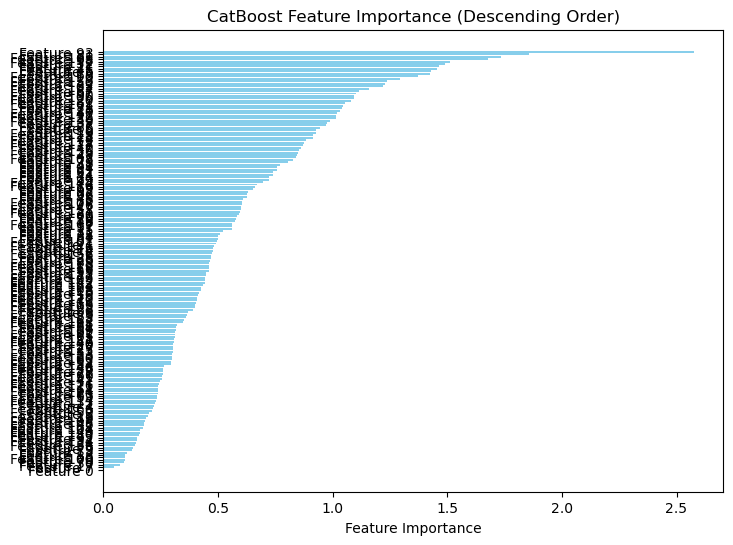

In [42]:
# feature importance visualize
cat_feature_importances = cat.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(cat_feature_importances))]

features_importance_sorted = sorted(zip(feature_names, cat_feature_importances), key=lambda x: x[1])
feature_names_sorted, feature_importances_sorted = zip(*features_importance_sorted)
print(features_importance_sorted)

plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance (Descending Order)')
plt.show()

In [57]:
# select feature
cat_threshold = 0.8

X_train_selected_cat = X_train[:, cat_feature_importances > cat_threshold]
X_valid_selected_cat = X_valid[:, cat_feature_importances > cat_threshold]

print(X_train_selected_cat.shape)
print(X_valid_selected_cat.shape)

(76743, 46)
(8527, 46)


In [59]:
# Re-Train model using selected feature
cat = CatBoostClassifier(
    iterations=8000,
    class_weights=class_weights,
    early_stopping_rounds=50,
    devices='0:1',
    verbose=True
)

cat.fit(X_train_selected_cat, y_train, eval_set=(X_valid_selected_cat, y_valid), verbose=10)

y_pred_val =  cat.predict(X_valid_selected_cat)

print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

Learning rate set to 0.053217
0:	learn: 1.0694085	test: 1.0691684	best: 1.0691684 (0)	total: 20.9ms	remaining: 2m 46s
10:	learn: 0.8964326	test: 0.8952293	best: 0.8952293 (10)	total: 149ms	remaining: 1m 48s
20:	learn: 0.8212723	test: 0.8193247	best: 0.8193247 (20)	total: 275ms	remaining: 1m 44s
30:	learn: 0.7818882	test: 0.7791391	best: 0.7791391 (30)	total: 444ms	remaining: 1m 54s
40:	learn: 0.7596339	test: 0.7558578	best: 0.7558578 (40)	total: 620ms	remaining: 2m
50:	learn: 0.7458587	test: 0.7418636	best: 0.7418636 (50)	total: 751ms	remaining: 1m 56s
60:	learn: 0.7371196	test: 0.7334530	best: 0.7334530 (60)	total: 871ms	remaining: 1m 53s
70:	learn: 0.7308840	test: 0.7274464	best: 0.7274464 (70)	total: 988ms	remaining: 1m 50s
80:	learn: 0.7253813	test: 0.7221627	best: 0.7221627 (80)	total: 1.11s	remaining: 1m 48s
90:	learn: 0.7219867	test: 0.7193959	best: 0.7193959 (90)	total: 1.23s	remaining: 1m 46s
100:	learn: 0.7184294	test: 0.7163313	best: 0.7163313 (100)	total: 1.34s	remaining: 1

#### Voting

In [60]:
def custom_predict(model, X):
    y_pred = model.predict(X)
    if y_pred.ndim > 1:
        y_pred = y_pred.reshape(-1)
    return y_pred

y_pred_rf = custom_predict(rf, X_valid_selected_rf)
y_pred_xgb = custom_predict(xgb, X_valid_selected_xgb)
y_pred_cat = custom_predict(cat, X_valid_selected_cat)

y_preds = np.vstack([y_pred_xgb, y_pred_rf, y_pred_cat])
y_pred_val = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=y_preds)

print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}")

F1-score on valid: 0.7976006079176582


### Output Result

In [61]:
df_test = pd.read_csv('test.csv')

df_test.head(5)

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21
0,26,8,62846.31,NaN,9,8,20,7,40,18.0,...,10.0,0,4073.62,32.455597,27,2,284.982920,182.480461,4.0,321.855869
1,26,8,44632.44,3419.370000,10,6,33,5,15,18.0,...,6.0,0,3409.13,39.326411,77,2,154.142311,394.730183,3.0,83.064506
2,41,9,28062.39,NaN,5,5,7,1,25,1.0,...,3.0,1,839.85,36.592743,217,1,14.835135,21.867753,5.0,443.050363
3,37,11,88406.34,NaN,2,7,12,4,10,3.0,...,3.0,1,1273.15,25.823064,378,1,242.236850,203.656866,4.0,515.425785
4,38,6,30739.30,2298.608333,4,4,13,6,15,10.0,...,4.0,2,1365.58,29.727568,213,2,135.238141,24.695750,4.0,319.926942


In [62]:
# Data Preprocess
X_test_num = num_imputer.transform(df_test.drop(categorical_features, axis=1))
X_test_cat = cat_imputer.transform(df_test[categorical_features])

X_test_num = sc.transform(X_test_num)
# X_test_cat = encoder.transform(X_test_cat).toarray()

# X_test = np.hstack([X_test_num, X_test_cat])
X_test = X_test_num
X_test = poly.transform(X_test)

print("Test shape:", X_test.shape)

Test shape: (6762, 171)


In [63]:
# feature selection
X_test_rf = X_test[:, rf_feature_importances > rf_threshold]
X_test_xgb = X_test[:, xgb_feature_importances > xgb_threshold]
X_test_cat = X_test[:, cat_feature_importances > cat_threshold]

In [75]:
# Single model predict
# y_pred = cat.predict(X_test_cat).flatten()
# y_pred = xgb.predict(X_test_xgb).flatten()
# y_pred = rf.predict(X_test_rf).flatten()

# voting predict
y_pred_rf = custom_predict(rf, X_test_rf)
y_pred_xgb = custom_predict(xgb, X_test_xgb)
y_pred_cat = custom_predict(cat, X_test_cat)
y_preds = np.vstack([y_pred_xgb, y_pred_rf, y_pred_cat])
y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=y_preds)

print(y_pred.shape)

(6762,)


In [76]:
# Output
output_df = pd.DataFrame({
    'Id': range(len(y_pred)),  
    'label': y_pred           
})

output_df.to_csv('output.csv', index=False)

print(output_df)
print("\nLabel Distribution:")
print(output_df['label'].value_counts().sort_index())

        Id  label
0        0      2
1        1      0
2        2      2
3        3      0
4        4      0
...    ...    ...
6757  6757      2
6758  6758      0
6759  6759      0
6760  6760      0
6761  6761      0

[6762 rows x 2 columns]

Label Distribution:
0    2756
1    1754
2    2252
Name: label, dtype: int64
